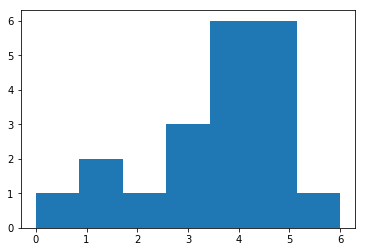

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

Y = [4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4]
plt.hist(Y, bins=7)
plt.show()

In [20]:
def comb(n, r):
    return math.factorial(n) // (math.factorial(n - r) * math.factorial(r))

x = np.arange(0.2,0.7,0.01)
z = sum([y * np.log(x) for y in Y]) + sum([(8-y)*np.log(1-x) for y in Y]) + sum([np.log(comb(8, y)) for y in Y])

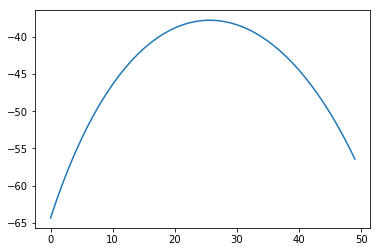

In [21]:
plt.plot(z)
plt.show()